## パイプライン

### パイプラインとは
#### 変換器(特徴量の生成と選択)と予測気を直列に繋げ，一連の処理をまとめて実行できるようにする仕組みのことをパイプラインと言う．
### メリット
1. いくつかの前処理を実行している場合でも，fit や predict をパイプラインに対して1度だけ呼ぶだけで良い
2. パイプラインに対して，グリッドサーチを行う際，パラメータを1度に指定できる．fit を読んだ後の変換器をキャッシュでき，性能向上が期待できる．
3. transformer と estimatorに同じデータが使われるため，交差検証の際にデータがリークされることを防げる

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 実装

1. GridSearchCV
2. クロスバリデーションをしながらパラメータチューニング
3. 評価指標の平均値を計算
4. パイプライン構築
    - グリッドサーチによる出力されたハイパーパラメータを使う
    - 前処理は，標準化，主成分分析による次元削除
    - 推定器には，重回帰，ランダムフォレストを使用
    - クロスバリデーションをしながら学習

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import pickle
from sklearn.model_selection import train_test_split, KFold, cross_val_score

# パラメーター調整
from sklearn.model_selection import GridSearchCV

# 変換器
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 予測器
from sklearn.ensemble import ExtraTreesRegressor,  GradientBoostingRegressor, RandomForestRegressor 


# パイプライン
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 評価関数
from sklearn.metrics import mean_squared_error, r2_score

# パイプラインの過程
from sklearn import set_config

### データの読み込み

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/boston.csv')

X = df.drop("house prices", axis=1)
y = df['house prices']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=53)

### 前処理

#### 特徴量選択

In [ ]:
features = [
            'INDUS',
            'RM',
            'TAX',
            'PTRATIO',
            'LSTAT'
]

#### 標準化

In [ ]:
scaler = StandardScaler()

#### 次元削除

次元削減にはPCAを使う．

In [ ]:
pca = PCA()

### パイプライン構築

In [ ]:
# 変換器パイプライン(前処理パイプライン)
## 前処理を行う
transformer = Pipeline(steps=[
                              ('StandScaler', scaler),
                              ('pca', pca),
])

# 特徴量 -> 変換器
preprocessor = ColumnTransformer(
    transformers=[('transform', transformer, features)]
)


In [ ]:
# 推定器の定義

gbr = GradientBoostingRegressor(
  random_state=53,
  min_samples_split = 5, 
  min_samples_leaf = 50,
  max_depth = 5,
  subsample = 0.8
)

etr = ExtraTreesRegressor(
    random_state=53,
    min_samples_split = 5,
    min_samples_leaf = 50,
    max_depth = 5,
    n_jobs=-1
)

rfr = RandomForestRegressor(
    max_depth=None,
    max_features='auto',
    max_leaf_nodes=None,
    min_samples_leaf=1,
    min_samples_split=2,
    n_jobs=-1,
    random_state=53,
    verbose=0
)

In [ ]:
## パイプライン全体：変換器パイプライン‐＞予測器（推定器）
pipe = Pipeline(
    steps=[
           ('preprocessor', preprocessor),
           ('regressor', gbr)
    ]
)

#### パラメータチューニング

グリッドサーチを行い，パラメータチューニングを行う

Scikit-Learnオブジェクトと GridSearchCVを組み合わせる場合，パラメータ名のみで良いが，Pipelineには複数のオブジェクトが含まれるため，それらを識別するための名前を追加する必要がある．

パラメータ名の前に，パイプラインを定義した際に推定器の’key+__’を付ける．今回の場合はregressor．

In [ ]:
# パラメータ
## 推定器は3つ

params_grid = [{'regressor':[gbr],
                'regressor__n_estimators': list(range(20, 101, 10)),
                'regressor__max_depth': [2, 3, 4, 6],
                'regressor__learning_rate': list(np.arange(0.05, 0.20, 0.01))},
               {'regressor': [etr],
                'regressor__n_estimators': [50, 75, 100, 125, 150],
                'regressor__max_depth': [2, 3, 4, 6]},    
               {'regressor': [rfr],
                'regressor__n_estimators': [50, 75, 100, 125, 150],
                'regressor__max_depth': [2, 3, 4, 6]}
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=params_grid,
    scoring='neg_root_mean_squared_error',
    cv=7,
    n_jobs = -1,
    refit=True,
    verbose=10
)


In [ ]:
gs.fit(X_train, y_train)

Fitting 7 folds for each of 616 candidates, totalling 4312 fits


GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('transform',
                                                                         Pipeline(steps=[('StandScaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         ['INDUS',
                                                                          'RM',
                                                                          'TAX',
                                                                          'PTRATIO',
                                                                          'LSTAT'])])),
                                       ('regressor',
                                        GradientBoostingRegressor(max_depth=5,
                                                                  min_samples_leaf=50,
                                                                  min_samples_split=5,
                                                                  random_state=53,
                                                                  subsample=0.8))]),
             n_jobs=-1,
             pa...
                                                            min_samples_split=5,
                                                            n_jobs=-1,
                                                            random_state=53)],
                          'regressor__max_depth': [2, 3, 4, 6],
                          'regressor__n_estimators': [50, 75, 100, 125, 150]},
                         {'regressor': [RandomForestRegressor(max_depth=6,
                                                              n_estimators=75,
                                                              n_jobs=-1,
                                                              random_state=53)],
                          'regressor__max_depth': [2, 3, 4, 6],
                          'regressor__n_estimators': [50, 75, 100, 125, 150]}],
             scoring='neg_root_mean_squared_error', verbose=10)

#### cv_results_ で列ヘッダーとしてのキーと列としての値を持つdictを呼び出せる．これは DataFrame インポートできる．今回は最も精度が良かったインデックスを表示．

In [ ]:
cv_result = pd.DataFrame(gs.cv_results_)
cv_result.loc[gs.best_index_]

mean_fit_time                                                              0.249776
std_fit_time                                                               0.010163
mean_score_time                                                            0.106824
std_score_time                                                             0.001683
param_regressor                   RandomForestRegressor(max_depth=6, n_estimator...
param_regressor__learning_rate                                                  NaN
param_regressor__max_depth                                                        6
param_regressor__n_estimators                                                    75
params                            {'regressor': RandomForestRegressor(max_depth=...
split0_test_score                                                         -3.785683
split1_test_score                                                         -3.548322
split2_test_score                                                         -4

In [ ]:
# 最も精度が高かった組合せのPipelineの過程
gs.best_estimator_

In [ ]:
 best_params = gs.best_params_
 best_params

{'regressor': RandomForestRegressor(max_depth=6, n_estimators=75, n_jobs=-1, random_state=53),
 'regressor__max_depth': 6,
 'regressor__n_estimators': 75}

In [ ]:
gs.best_score_

-3.9959508549034686

In [ ]:
gs.score(X_test, y_test)

-4.5398853523667935

In [ ]:
pred = gs.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

In [ ]:
print(f'RMSE: {rmse}')
print(f'R2: {r2}')

RMSE: 4.5398853523667935
R2: 0.7737368412361636


### GridSearchCV結果の可視化
ヒートマップを使って結果の可視化を行う．

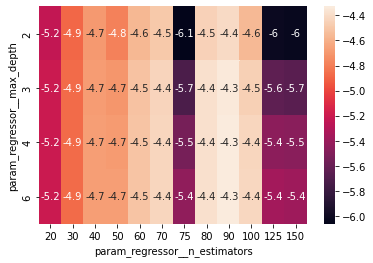

In [ ]:
import seaborn as sns

cv_result = cv_result[['param_regressor__max_depth', 'param_regressor__n_estimators', 'mean_test_score']]
cv_result_pivot = cv_result.pivot_table('mean_test_score', 'param_regressor__max_depth', 'param_regressor__n_estimators')

heat_map = sns.heatmap(cv_result_pivot, annot=True);